# K-Means <br>
<div>K-Means is a non-supervised learning algoritm that groups similiar examples in one of the K clusters. Every cluster has a centroid, which is the average of the examples that belong to that cluster.</div>

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import seaborn as sns

### Importing the Iris Dataset

In [2]:
iris = load_iris()
data = sns.load_dataset('iris')
X = iris.data

### Cost Function (Distorion)<br>
<div>It's the mean of the square Euclidean Distance between every example and every centroid.</div>
<img src='https://www.packtpub.com/sites/default/files/Article-Images/8365OS_06_04.png' width='200'>

In [3]:
def distance(a, b):
    return np.sqrt(np.sum((a-b)**2))

def cost_func(clusters,mus):
    cost = 0
    m = 0
    
    for cluster_i, examples in clusters.items():
        for example in examples:
            cost += ( distance(example, mus[cluster_i]) )**2
        m += len(examples)
    
    return np.sum(cost)/m

### K-Means
<br>
<div>K-Means has 2 distinct phases:
 <br>
    <b>Cluster Assignment:</b> Computes distance between every example and every centroid, and assigns examples to the cluster which has the closest centroid
    <br>
    <b>Move Centroids:</b> Recalculates centroids as the mean of every example in it's respective cluster      <br>
 <br>
    <b>Note:</b> If a cluster, at some point, has 0 elements in it, then reset it's centroid and redo the Cluster Assignment phase. Another way to fix this is by simply deleting that cluster and converging with K-1 clusters</div>

In [4]:
def cluster_assignment(X, clusters,distances):
    """ Assigns examples to a cluster based on it's proximity to the cluster centroid """
    for example_i, dists in enumerate(distances):
        clusters[np.argmin(dists)].append(X[example_i])
    
    return clusters

def dist_example_centroids(X,centroids):
    """ Calculates the distance between every example and every centroid """
    distances = []
    for i, example in enumerate(X):
        inner = []
        for j, centroid in enumerate(centroids):
            inner.append(distance(centroid, example))
        distances.append(inner)  
        
    return distances
    
def K_Means(X, K=3, threshold=1e-3, maxit=200):
    
                    ############### INITIALIZING VARIABLES ###############
    
    difference_between_costs = threshold + 1
    centroids = []
    clusters = {}
    it = 0
    costs = [0,0] # Has to have 2 numbers so that cost - costs[len(costs)-2] works
    
    # Initializes centroids as random data samples
    for i in range(K):
        centroid_i = np.random.randint(low=0, high=len(X), size=1)
        centroids.append(X[centroid_i])
        
                    ######################################################
            
    while difference_between_costs > 1e-3 and it < maxit:
        
                    ############### CLUSTER ASSIGNMENT PHASE ###############
        
        # Calculates the distance between every example and every centroid 
        distances = dist_example_centroids(X,centroids)
    

        for i in range(K):
            clusters[i] = [] # Initializing clusters
        
        # Assigns examples to it's closest cluster centroid
        clusters = cluster_assignment(X, clusters, distances)
        
        #Resetting centroid and redoing if it's cluster is empty
        for cluster_i, cluster in clusters.items(): 
            while len(clusters[cluster_i]) == 0:
                centroids[cluster_i] = X[np.random.randint(low=0, high=len(X), size=1)] # Reset centroid
                distances = dist_example_centroids(X,centroids) # Recalculates distances
                clusters = cluster_assignment(X, clusters,distances) # Reassigns clusters
                
                ########################################################
        
        # Compute cost  
        cost = cost_func(clusters,centroids)

        
                ############### MOVE CENTROIDS PHASE ###################
        
        for centroid_i in range(K):
            centroids[centroid_i] = np.average(a=clusters[centroid_i],axis=0)
            
                ########################################################
        
        costs.append(cost)
        difference_between_costs = np.sqrt((cost - costs[len(costs)-2])**2)
        
        it += 1
        
        for i in range(K): # Transforming lists to arrays
            clusters[i] = np.array(clusters[i])
            
    print("\nConverged at " + str(it) + "th iteration.")
    return (clusters, np.array(centroids), cost)

### Model Selection
<br>
<div> Since K-Means doens't aways finds the global minima for the cost function, it's result may vary upon the initialization of the centroids. A reasonable thing to do then is to run K-Means n times and get the best model (the one with lower cost).</div>

In [5]:
def model_selection(data, algorithm=K_Means, K=3, threshold= 1e-3, n_times=100):
    it = 0
    
    results = {}
    clusters = []
    centroids = []
    costs = []
    
    while it < n_times:
        result = {}
        
        cluster, centroid, cost = K_Means(X=X,K=K,threshold=threshold)
        print('Model',it, 'Cost:',cost)
        clusters.append(cluster)
        centroids.append(centroid)
        costs.append(cost)
        
        result = {'cluster':cluster, 'centroid':centroid, 'cost':cost}
        results[it] = result
        it += 1
        
    costs = []
    for i in results.keys():
        costs.append(results[i]['cost'])
        
    return results[np.argmin(costs)]

In [6]:
model = model_selection(X,K=3,n_times=5)


Converged at 8th iteration.
Model 0 Cost: 0.5257044388398487

Converged at 9th iteration.
Model 1 Cost: 0.5256762761743068

Converged at 6th iteration.
Model 2 Cost: 0.5257044388398482

Converged at 15th iteration.
Model 3 Cost: 0.525704438839849

Converged at 10th iteration.
Model 4 Cost: 0.5257044388398482


In [7]:
# Best model's cost
model['cost']

0.5256762761743068

In [8]:
# Best model's centroids
model['centroid']

array([[5.006     , 3.428     , 1.462     , 0.246     ],
       [5.9016129 , 2.7483871 , 4.39354839, 1.43387097],
       [6.85      , 3.07368421, 5.74210526, 2.07105263]])

### Visualizing the Results

In [9]:
# Matrix with all clusters
points = np.concatenate((model['cluster'][0],model['cluster'][1],model['cluster'][2]),axis=0)

# Dataframe with all clusters
df = pd.DataFrame(points, columns=iris.feature_names)
df['class'] = 'zero'
df.loc[50:100,'class'] = 'one' 
df.loc[100:,'class'] = 'two'

# Dataframe with centroids and clusters
centroids = pd.DataFrame(model['centroid'], columns=iris.feature_names)
centr_clust = pd.concat((centroids,df.iloc[:,:4]))

In [10]:
def set_colors(data):    
    colors = []
    for i, ex in data.iterrows():
        if np.asarray(ex[:4]) in model['centroid']:
            colors.append('red')
        elif i<50:
            colors.append('green')
        elif i >=50 and i <100:
            colors.append('blue')
        else:
            colors.append('orange')
            
    return colors

This figure might seem odd as some examples seem closer to a centroid but are categorized as another class, but that's because this is a 2d representation. The model is 4D, and in that dimension, points closer to the centroid are actually part of it's cluster

Text(0, 0.5, 'Sepal Width')

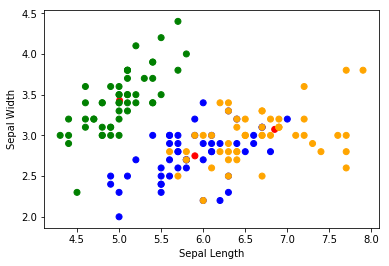

In [11]:
# Sepal Length vs Sepal Width
plt.scatter(centr_clust.iloc[:,0], centr_clust.iloc[:,1], c=set_colors(centr_clust), marker='o')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')

# Note: Red dots are the cluster centroids

### Model

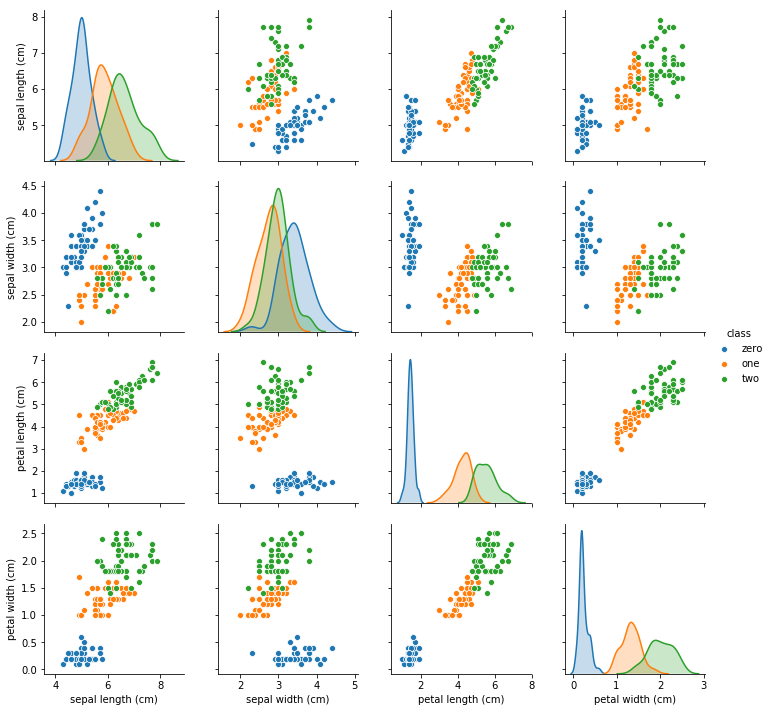

In [12]:
sns.pairplot(df,hue='class')

### Original

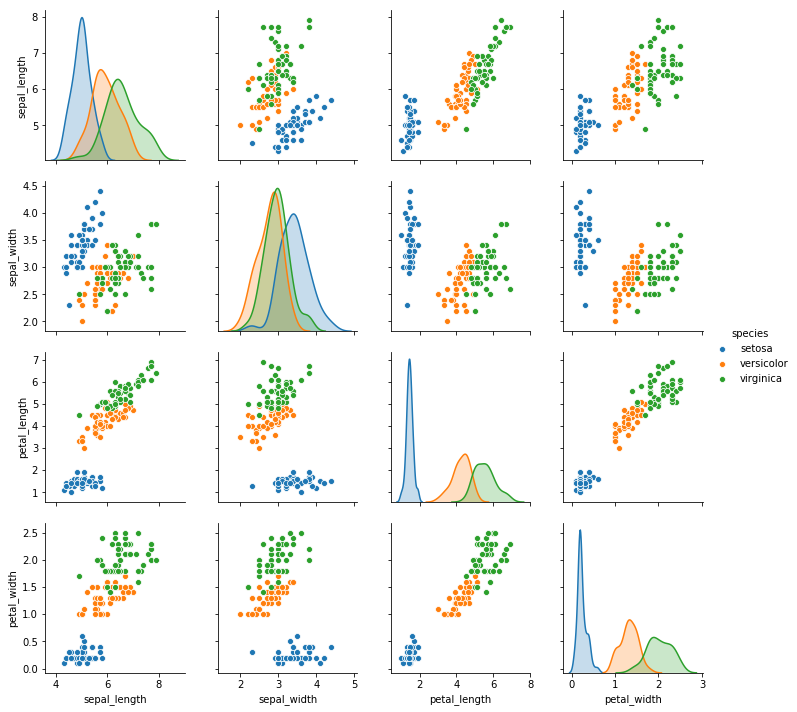

In [13]:
sns.pairplot(data, hue='species')